In [1]:
import torch
from torch import nn
import transformers
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(torch.__version__)
print(transformers.__version__)

2.1.2+cu121
4.28.0


### 1. text classification
- sequence classification
- sentiment analysis
     - 情感分析，一种文本分类
        - 电商评论
        - social web

### 1.1 emotion数据集

In [3]:
from datasets import load_dataset

In [4]:
emotions = load_dataset('emotion')
emotions

e:\anaconda\envs\unet\lib\site-packages\datasets\load.py:1454: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
emotions.keys()

dict_keys(['train', 'validation', 'test'])

In [6]:
print(emotions['train'], type(emotions['train']))
print(emotions['train']['text'][:5])
print(emotions['train']['label'][:5])
print(emotions['train'][:5])

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
}) <class 'datasets.arrow_dataset.Dataset'>
['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']
[0, 0, 3, 2, 3]
{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [7]:
print(emotions['train'].features)
print(emotions['train'].features['label'])
print(emotions['train'].features['label'].int2str(2))

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)
love


In [8]:
labels = emotions['train'].features['label'].names
print(labels)
num_classes = len(labels)
num_classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


6

In [9]:
def int2str(x):
    return labels[x]

### 1.2 data visualization analysis
- dataset -> dataframe
- text length
- label freq

### 1.2.1 dataset to dataframe

In [10]:
emotions_df = pd.DataFrame.from_dict(emotions['train'])


In [11]:
print(emotions_df.shape, emotions_df.columns)
emotions_df[:5]

(16000, 2) Index(['text', 'label'], dtype='object')


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [12]:
emotions_df['label_name'] = emotions_df['label'].apply(lambda x: labels[x])

In [13]:
emotions_df[:5]

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### 1.2.2 label analysis

In [14]:
emotions_df.label.value_counts()

label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64

In [15]:
emotions_df.label_name.value_counts()

label_name
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

Text(0.5, 1.0, 'freq of labels')

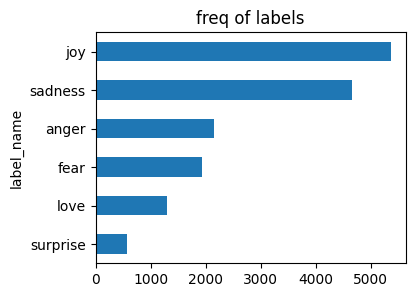

In [16]:
plt.figure(figsize=(4,3))
emotions_df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('freq of labels')

### 1.2.3 text length analysis

Text(0.5, 0, '')

<Figure size 400x300 with 0 Axes>

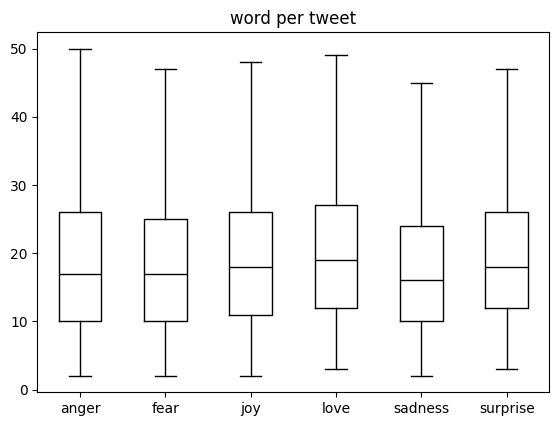

In [17]:
plt.figure(figsize=(4,3))
emotions_df['word per tweet'] = emotions_df['text'].str.split().apply(len)
emotions_df.boxplot('word per tweet', by='label_name',
                    showfliers=False,
                    grid=False,
                    color='black')
plt.suptitle('')                
plt.xlabel('')

In [18]:
print(emotions_df['word per tweet'].max())
print(emotions_df['word per tweet'].idxmax())

66
6322


In [19]:
print(emotions_df['word per tweet'].min())
print(emotions_df['word per tweet'].idxmin())

2
4150


In [20]:
emotions_df.iloc[4150]

text              earth crake
label                       4
label_name               fear
word per tweet              2
Name: 4150, dtype: object

### 1.3 text -> token
数据集转化为模型输入
- subword tokenization
    - wordpiece
        - bert and distilbert
- huggingface
    - /.cache/huggingface
- tokenizer
    - tokenizer.vocab_size
    - model config
        - tokenizer.model_max_length
        - tokenizer.model_input_names

### 1.3.1 tokenizer

In [21]:
from transformers import AutoTokenizer

In [22]:
model_ckpt = 'distilbert-base-uncased' # 不区分大小写
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [23]:
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)

30522
512
['input_ids', 'attention_mask']


In [24]:
for special_id in tokenizer.all_special_ids:
    print(special_id, tokenizer.decode(special_id))

100 [UNK]
102 [SEP]
0 [PAD]
101 [CLS]
103 [MASK]


### 1.3.2 tokenize the whole dataset

In [25]:
def batch_tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [26]:
emotions_encoded = emotions.map(batch_tokenize, batched=True, batch_size=None)

In [27]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [28]:
# list to tensor
emotions_encoded.set_format('torch', columns=['label', 'input_ids', 'attention_mask'])


In [29]:
type(emotions_encoded['train']['input_ids'])

torch.Tensor

### 2. fine tune transformers

### 2.1 distilbert-base-uncased
- distilbert是对bertdistil而来
     - 模型结构更简单
        - distilbert参数量66362880
        - bert参数量109482240

In [30]:
from transformers import AutoModel

In [31]:
model_ckpt = 'distilbert-base-uncased'
model = AutoModel.from_pretrained(model_ckpt)
model_ckpt

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'distilbert-base-uncased'

In [32]:
from transformers_utils import get_params

In [33]:
get_params(model)

66362880

In [34]:
from transformers import AutoModelForSequenceClassification

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ckpt = 'distilbert-base-uncased'
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_classes).to(device)
model


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### 2.2 trainer

In [36]:
from huggingface_hub import notebook_login
notebook_login()

In [37]:
from transformers import TrainingArguments, Trainer

In [38]:
batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f'{model_ckpt}_emotion_ft'
training_args = TrainingArguments(output_dir=model_name,
                                    num_train_epochs=4,
                                    learning_rate=2e-5,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    weight_decay=0.01,
                                    evaluation_strategy='epoch',
                                    disable_tqdm=logging_steps,
                                    push_to_hub=True,
                                    log_level='error')

In [39]:
from transformers_utils import compute_classification_metrics
trainer = Trainer(model=model,
                    tokenizer=tokenizer,
                    train_dataset=emotions_encoded['train'],
                    eval_dataset=emotions_encoded['validation'],
                    args=training_args,
                    compute_metrics=compute_classification_metrics)

e:\anaconda\envs\unet\lib\site-packages\huggingface_hub\utils\_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
e:\kennys\AIGC\gpt\distilbert-base-uncased_emotion_ft is already a clone of https://huggingface.co/shykennys/distilbert-base-uncased_emotion_ft. Make sure you pull the latest changes with `repo.git_pull()`.


In [40]:
trainer.train()

e:\anaconda\envs\unet\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.27277109026908875, 'eval_accuracy': 0.9155, 'eval_f1': 0.9137580318054142, 'eval_precision': 0.9033928653588218, 'eval_runtime': 2.5882, 'eval_samples_per_second': 772.748, 'eval_steps_per_second': 12.364, 'epoch': 1.0}
{'loss': 0.5164, 'learning_rate': 1e-05, 'epoch': 2.0}
{'eval_loss': 0.1792825311422348, 'eval_accuracy': 0.9275, 'eval_f1': 0.9280041244643861, 'eval_precision': 0.8951417270763614, 'eval_runtime': 2.756, 'eval_samples_per_second': 725.701, 'eval_steps_per_second': 11.611, 'epoch': 2.0}
{'eval_loss': 0.15524086356163025, 'eval_accuracy': 0.935, 'eval_f1': 0.9354093786093406, 'eval_precision': 0.9036388685433504, 'eval_runtime': 2.4564, 'eval_samples_per_second': 814.209, 'eval_steps_per_second': 13.027, 'epoch': 3.0}
{'loss': 0.1258, 'learning_rate': 0.0, 'epoch': 4.0}
{'eval_loss': 0.15286403894424438, 'eval_accuracy': 0.934, 'eval_f1': 0.9344783366934866, 'eval_precision': 0.9052089351876242, 'eval_runtime': 2.7389, 'eval_samples_per_second': 730.221,

TrainOutput(global_step=1000, training_loss=0.32106589126586915, metrics={'train_runtime': 310.0072, 'train_samples_per_second': 206.447, 'train_steps_per_second': 3.226, 'train_loss': 0.32106589126586915, 'epoch': 4.0})

In [42]:
preds_output = trainer.predict(emotions_encoded['validation'])
preds_output

PredictionOutput(predictions=array([[ 5.8305798 , -0.76961035, -1.3316387 , -0.80540884, -0.7516071 ,
        -1.5086389 ],
       [ 5.818175  , -0.8309649 , -1.8041495 , -0.69197917, -0.38868874,
        -1.4985797 ],
       [-1.3405722 ,  2.7443554 ,  3.848587  , -1.1760296 , -2.6597872 ,
        -1.6386486 ],
       ...,
       [-1.0925596 ,  5.7920685 , -0.20897566, -0.8526862 , -1.7788235 ,
        -1.6003879 ],
       [-1.6634498 ,  3.653442  ,  3.4525907 , -1.2441489 , -2.6215065 ,
        -1.5433067 ],
       [-1.4810216 ,  5.7518463 , -0.30875084, -1.4517955 , -1.8284833 ,
        -0.6311785 ]], dtype=float32), label_ids=array([0, 0, 2, ..., 1, 1, 1], dtype=int64), metrics={'test_loss': 0.15286403894424438, 'test_accuracy': 0.934, 'test_f1': 0.9344783366934866, 'test_precision': 0.9052089351876242, 'test_runtime': 2.7323, 'test_samples_per_second': 731.974, 'test_steps_per_second': 11.712})

In [43]:
import numpy as np
preds_output = trainer.predict(emotions_encoded['validation'])
y_pred = np.argmax(preds_output.predictions, axis=-1)

In [45]:
y_true = emotions_encoded['validation']['label']

In [53]:
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [50]:
# from transformers_utils import plot_confusion_matrix

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(4,4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")

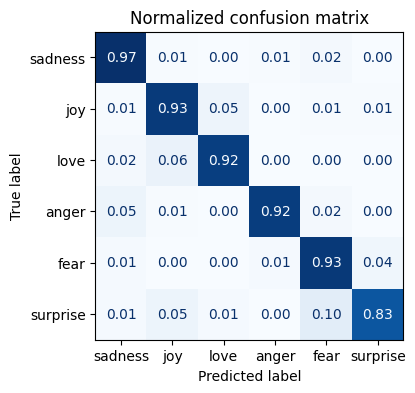

In [57]:
plot_confusion_matrix(y_pred, y_true, labels)

### 3. result analysis

In [58]:
from torch.nn.functional import cross_entropy

In [59]:
def forward_pass_with_label(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
                if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch['label'].to(device),
        reduction='none')

    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [60]:
emotions_encoded['validation'] = emotions_encoded['validation'].map(
    forward_pass_with_label, batched=True, batch_size=16
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [61]:
emotions_encoded['validation']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label'],
    num_rows: 2000
})

In [62]:
selected_cols = ['text', 'label','loss', 'predicted_label']

In [63]:
valid_df = pd.DataFrame.from_dict({'text': emotions_encoded['validation']['text'],
                                    'label': emotions_encoded['validation']['label'].numpy(),
                                    'pred_label': emotions_encoded['validation']['predicted_label'].numpy(),
                                    'loss': emotions_encoded['validation']['loss'].numpy()})
valid_df['label'] = valid_df['label'].apply(lambda x: int2str(x))
valid_df['pred_label'] = valid_df['pred_label'].apply(lambda x: int2str(x))


In [64]:
valid_df

,text,label,pred_label,loss
0,im feeling quite sad and sorry for myself but ...,sadness,sadness,0.005467
1,i feel like i am still looking at a blank canv...,sadness,sadness,0.005935
2,i feel like a faithful servant,love,love,0.299547
3,i am just feeling cranky and blue,anger,anger,0.007591
4,i can have for a treat or if i am feeling festive,joy,joy,0.004236
...,...,...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness,sadness,0.007202
1996,i constantly worry about their fight against n...,joy,joy,0.005208
1997,i feel its important to share this info for th...,joy,joy,0.005914
1998,i truly feel that if you are passionate enough...,joy,joy,0.608582


In [67]:
valid_df[valid_df['label'] != valid_df['pred_label']]

,text,label,pred_label,loss
17,i know what it feels like he stressed glaring ...,anger,sadness,1.784452
27,i feel as if i am the beloved preparing hersel...,joy,love,1.165630
35,i am feeling very blessed today that they shar...,joy,love,0.975629
55,i didn t feel accepted,joy,love,0.867045
91,i feel like the people i know are really gener...,joy,love,1.788608
...,...,...,...,...
1950,i as representative of everything thats wrong ...,surprise,sadness,6.385432
1963,i called myself pro life and voted for perry w...,joy,sadness,5.906774
1981,i spent a lot of time feeling overwhelmed with...,fear,surprise,1.265830
1990,i just feel too overwhelmed i can t see the fo...,fear,surprise,1.355782


In [68]:
valid_df[valid_df['label'] != valid_df['pred_label']].label.value_counts()

label
joy         49
anger       23
sadness     17
love        15
fear        14
surprise    14
Name: count, dtype: int64

In [69]:
valid_df.sort_values('loss', ascending=False).head(10)

,text,label,pred_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,7.181260
1950,i as representative of everything thats wrong ...,surprise,sadness,6.385432
1963,i called myself pro life and voted for perry w...,joy,sadness,5.906774
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.369802
1111,im lazy my characters fall into categories of ...,joy,fear,4.992860
1836,i got a very nasty electrical shock when i was...,fear,anger,4.742038
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.658793
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.332168
1683,i had applied for a job and they had assured m...,anger,joy,4.153783
1509,i guess this is a memoir so it feels like that...,joy,fear,4.030654


### 4. to huggingface hub

In [70]:
trainer.push_to_hub(commit_message='Training Completed!')

To https://huggingface.co/shykennys/distilbert-base-uncased_emotion_ft
   475c86b..f14978d  main -> main



In [72]:
from transformers import pipeline

In [76]:
model_id = 'shykennys/distilbert-base-uncased_emotion_ft'
classifier = pipeline('text-classification', model=model_id)

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [77]:
custom_tweet = 'I saw a movie today and it was really good.'
preds = classifier(custom_tweet, return_all_scores=True)
preds

e:\anaconda\envs\unet\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'LABEL_0', 'score': 0.004324452020227909},
  {'label': 'LABEL_1', 'score': 0.9840177893638611},
  {'label': 'LABEL_2', 'score': 0.0018599526956677437},
  {'label': 'LABEL_3', 'score': 0.005542389117181301},
  {'label': 'LABEL_4', 'score': 0.0018497671699151397},
  {'label': 'LABEL_5', 'score': 0.0024056220427155495}]]

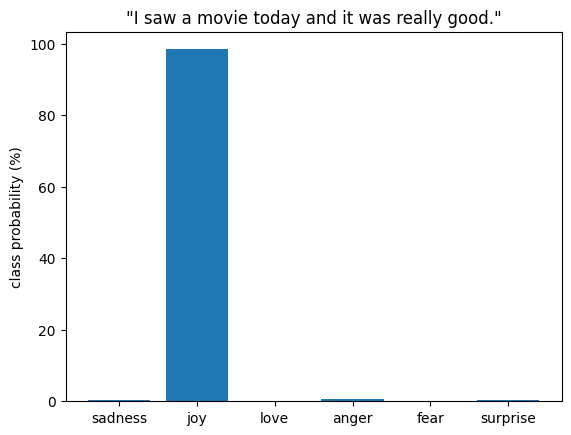

In [82]:
pred_df = pd.DataFrame(preds[0])
plt.bar(labels, 100*pred_df['score'], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("class probability (%)")
plt.show()